In [2]:
import glob
import os
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.layers import Conv2D, MaxPool2D, Concatenate, Flatten, Dense

In [3]:
EPOCHS = 1000
RESULT_SAVE_PATH = 'results/'

In [4]:
def Model():
    def inception(filters):
        def subnetwork(x):
            h1 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
            h1 = MaxPool2D()(h1)
            
            h2 = Conv2D(filters // 2, (1, 1), padding='same', activation='relu')(x)
            h2 = Conv2D(filters, (3, 3), padding='same', activation='relu')(h2)
            h2 = MaxPool2D()(h2)
            
            h3 = Conv2D(filters // 2, (1, 1), padding='same', activation='relu')(x)
            h3 = Conv2D(filters, (5, 5), padding='same', activation='relu')(h3)
            h3 = MaxPool2D()(h3)
            return Concatenate()([h1, h2, h3])
        return subnetwork
    
    x = tf.keras.Input(shape=(256, 256, 3))
    h = inception(16)(x)
    h = inception(32)(h)
    h = inception(32)(h)
    h = inception(32)(h)
    h = inception(32)(h)
    h = Flatten()(h)
    h = Dense(1024, activation='relu')(h)
    y = Dense(1, activation='sigmoid')(h)
    return tf.keras.Model(inputs=x, outputs=y)

In [5]:
def preprocess(img):
    return tf.image.convert_image_dtype(img, tf.float32)

In [6]:
def augmentation(img, label):
    def flip(x):
        x = tf.image.random_flip_left_right(x)
        x = tf.image.random_flip_up_down(x)
        return x
    
    def rotate(x):
        x = tf.cond(tf.random.uniform(shape=[], minval=0.0, maxval=1.0, dtype=tf.float32) > 0.5,
                   lambda: tfa.image.rotate(x,
                                       tf.random.uniform(shape=[], minval=0.0, maxval=360.0, dtype=tf.float32),
                                       interpolation='BILINEAR'),
                   lambda: x)
        return x
    
    def translation(x):
        dx = tf.random.uniform(shape=[], minval=-10.0, maxval=10.0, dtype=tf.float32)
        dy = tf.random.uniform(shape=[], minval=-10.0, maxval=10.0, dtype=tf.float32)
        x = tf.cond(tf.random.uniform(shape=[], minval=0.0, maxval=1.0, dtype=tf.float32) > 0.5,
                    lambda: tfa.image.transform(x,
                                                [0, 0, dx, 0, 0, dy, 0, 0],
                                                interpolation='BILINEAR'),
                    lambda: x)
        return x
    
    img = flip(img)
    img = rotate(img)
    img = translation(img)
           
    return img, label

In [12]:
tffiles = glob.glob('tf/records/*')
raw_image_dataset = tf.data.TFRecordDataset(tffiles)

image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

def _parse_image_label(parsed_dataset):
    return preprocess(tf.image.decode_png(parsed_dataset['image_raw'])), parsed_dataset['label']

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
dataset = parsed_image_dataset.map(_parse_image_label)
ds_size = 0
for _ in dataset:
    ds_size += 1
print(ds_size)

2480


In [13]:
train_size = int(ds_size * 0.7)

ds = dataset.shuffle(ds_size)
ds_train = ds.take(train_size).shuffle(1024, reshuffle_each_iteration=True).prefetch(1024).batch(32).map(augmentation)
ds_valid = ds.skip(train_size).prefetch(1024).batch(32)

In [14]:
model = Model()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=1)
history = model.fit(ds_train,
                    validation_data=ds_valid,
                    epochs=EPOCHS,
                    callbacks=[earlystopping])

Epoch 1/1000
     55/Unknown - 217s 4s/step - loss: 0.7074 - accuracy: 0.5012

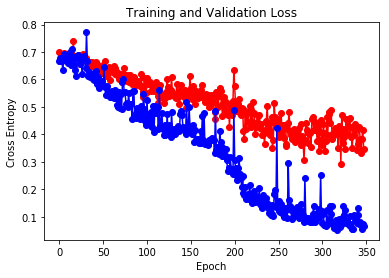

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(loss, 'ro-')
plt.plot(val_loss, 'bo-')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
model.save('model/inception_model.h5')